In [2]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import random

from lifelines.plotting import plot_lifetimes

/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /home/yannick/bin/anaconda3/envs/py27/lib/python2.7/argparse.pyc, but /home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


In [10]:
N = 100
obs_time = 10
random.seed(1234)

lifetime = pm.rweibull(2, 5, size=N)
birth = pm.runiform(0, obs_time, N)

In [22]:
# new model

censor = (lifetime + birth) > obs_time

observed_lifetime = lifetime.copy()
observed_lifetime[censor] = obs_time - birth[censor]

alpha = pm.Uniform("alpha", 0, 20)
beta = pm.Uniform("beta", 0, 20)

# a bit of dark magic here. not sure about the sum(...) formula

@pm.observed
def survival1(value=observed_lifetime,
             alpha=alpha, beta=beta):
    return sum((1-censor) *
               (np.log(alpha/beta) 
                + (alpha-1)*np.log(value/beta))
                - (value/beta)**alpha)

@pm.observed
def survival(value=observed_lifetime,
             alpha=alpha, beta=beta):
    return sum((1-censor) *
                   (np.log(alpha/beta) 
                    + (alpha-1)*np.log(value/beta)
                    - (value/beta)**alpha))

mcmc = pm.MCMC([alpha, beta, survival])
mcmc.sample(10000, 1000)

alpha_t = mcmc.trace("alpha")[:]
beta_t = mcmc.trace("beta")[:]

 [-----------------100%-----------------] 10000 of 10000 complete in 8.4 sec

(3.6244063014065442, 2.7915684411050763, 4.1160095393315359)


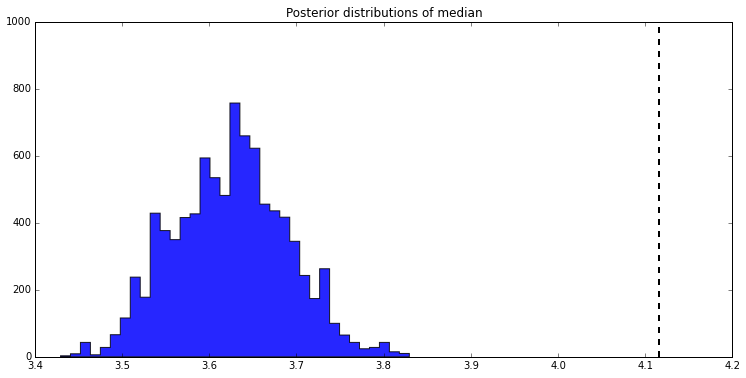

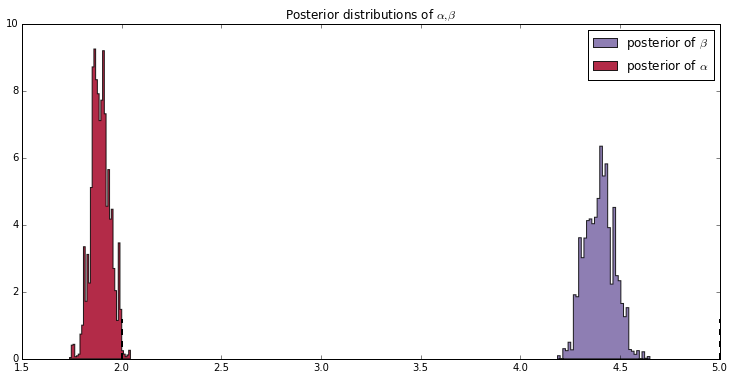

In [24]:
medians = beta_t * np.log(2) ** (1/alpha_t)
print (medians.mean(), np.median(observed_lifetime), np.median(lifetime))

figsize(12.5, 6)

# histogram of median samples:
plt.title(r"Posterior distributions of median")
plt.hist(medians, histtype='stepfilled', bins=35, alpha=0.85)
plt.vlines(np.median(lifetime), 0, 1000, lw=2, linestyles="--")
plt.legend()
plt.show()

figsize(12.5, 6)

# histogram of the samples:
plt.title(r"Posterior distributions of $\alpha, \beta$")
plt.hist(beta_t, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.hist(alpha_t, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.vlines(2, 0, 1.2, lw=2, linestyles="--")
plt.vlines(5, 0, 1.2, lw=2, linestyles="--")

_ = plt.legend()

Plotting alpha
Plotting beta


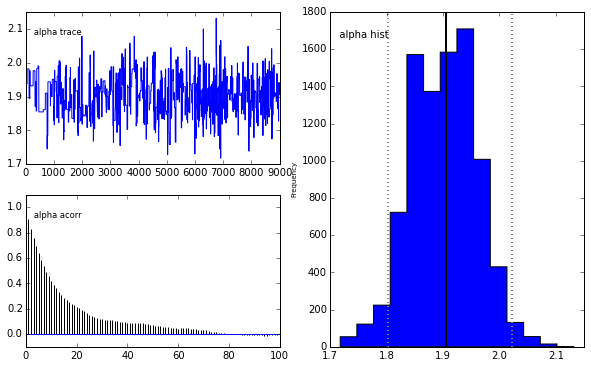

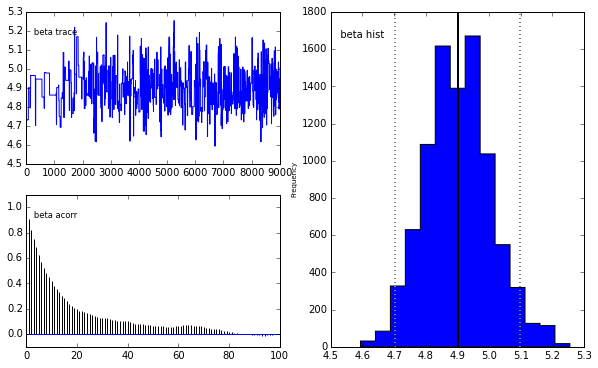

In [17]:
pm.Matplot.plot(mcmc)

nan
